In [8]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import selfies as sf
from rdkit import rdBase
#from rdkit import RDLogger

rdBase.DisableLog('rdApp.*')

from scipy.stats import percentileofscore


In [48]:
zinc_df = pd.read_csv('../moses/dataset/data/ZINC250K/train.csv')

file_path = 'after_optim/'

selfies_500 = pd.read_csv(f'{file_path}vae_prop_selfies_all_n500_ep200.csv')
selfies_1000 = pd.read_csv(f'{file_path}vae_prop_selfies_all_n1000_ep200.csv')
selfies_2000 = pd.read_csv(f'{file_path}vae_prop_selfies_all_n2000_ep200.csv')

smiles_500 = pd.read_csv(f'{file_path}vae_prop_smiles_all_n500_ep200.csv')
smiles_1000 = pd.read_csv(f'{file_path}vae_prop_smiles_all_n1000_ep200.csv')
smiles_2000 = pd.read_csv(f'{file_path}vae_prop_smiles_all_n2000_ep200.csv')

selfies_500.head()

,gen_SELFIES,gen_SMILES,gen_qed,gen_sa,obj,iter,z_value
0,[C][C][C][C][C][C][N][Ring1][=Branch1][C][=Bra...,CC1CCCCN1C(=O)CN2CCN(C3=CC=CC=C3F)CC2,0.855550,2.394007,1.883742,0,[ 0.08294201 -4.035322 2.0622048 -4.086691...
1,[C][C][=C][C][=C][C][Branch2][Ring1][Ring1][N]...,CC1=CC=CC(NC(=O)CCC=2C(C)=NOC=2C)=C1,0.915983,1.874196,2.705721,1,[-3.99978 1.9933243 0.74753714 -2.947707...
2,[C][C][C][C][C][C][N][Ring1][=Branch1][C][=Bra...,CC1CCCCN1C(=O)C2CCCN(C(=O)C3=CC=C(F)C=C3F)C2,0.821695,2.817106,1.291371,2,[ 3.6330247 -1.6655517 -2.4053578 2.888466...
3,[C][C][=C][C][=C][Branch2][Ring1][=N][C][=Bran...,CC1=CC=C(C(=O)N2CCCC(C3=NOC(C(C)C)=N3)C2)C=C1,0.869619,2.630970,1.717124,3,[ 2.0000467 -0.17462254 3.890027 1.012991...
4,[C][C][=C][C][=C][Branch2][Ring1][=N][C][=Bran...,CC1=CC=C(C(=O)N2CCCC(C3=NOC(C(C)C)=N3)C2)C=C1,0.869619,2.630970,1.717124,4,[ 1.4222941 1.9887533 -1.9567058 -2.659507...


In [49]:
zinc_df

,SMILES,SELFIES,logP,qed,SAS,obj
0,COCCOc1ccc(CNC(=O)c2cnc3ccc(C)cn23)cc1,[C][O][C][C][O][C][=C][C][=C][Branch2][Ring1][...,2.59792,0.672152,2.174005,1.186756
1,Cc1cc(C(=O)NC(C)(C)c2cccc(F)c2)[nH]n1,[C][C][C][=C][Branch2][Ring1][Branch2][C][=Bra...,2.52232,0.891576,2.577987,1.879891
2,CCc1n[nH]c(SCc2nnnn2-c2cc(C)ccc2F)n1,[C][C][C][=N][NH1][C][Branch2][Ring1][=Branch1...,2.08262,0.724791,2.787800,0.836156
3,COc1ccc(CC(=O)Nc2cccc3ncccc23)cc1,[C][O][C][=C][C][=C][Branch2][Ring1][Branch1][...,3.42460,0.801260,1.647545,2.358755
4,CCOc1ccc(Cl)c(C(=O)Nc2cc(C)nn2CCC#N)n1,[C][C][O][C][=C][C][=C][Branch1][C][Cl][C][Bra...,2.80460,0.876945,2.582261,1.802464
...,...,...,...,...,...,...
249995,CCNC(=O)c1ccc(NC(=O)NCCc2ccncc2C)c(C)c1,[C][C][N][C][=Branch1][C][=O][C][=C][C][=C][Br...,2.81234,0.755988,2.094851,1.685089
249996,CCn1c(SCCC(=O)OC)nnc1-c1ccncc1,[C][C][N][C][Branch1][#Branch2][S][C][C][C][=B...,2.01520,0.599004,2.200160,0.794861
249997,Cc1cccc(C(=O)N2CCCN(C(=O)c3cc(Cl)c[nH]3)CC2)c1,[C][C][=C][C][=C][C][Branch2][Ring1][=C][C][=B...,2.96482,0.909341,2.126423,2.420282
249998,Cc1noc(COCC(=O)NC(C)c2ccccc2Cl)n1,[C][C][=N][O][C][Branch2][Ring1][=Branch1][C][...,2.42542,0.886423,2.661238,1.770879


In [53]:
opt_dfs = [smiles_500, selfies_500, smiles_1000, selfies_1000, smiles_2000, selfies_2000]
model_names = ['smiles_500', 'selfies_500', 'smiles_1000', 'selfies_1000', 'smiles_2000', 'selfies_2000']


0 unique: 31/200
1 unique: 130/200
2 unique: 23/200
3 unique: 130/200
4 unique: 28/200
5 unique: 140/200


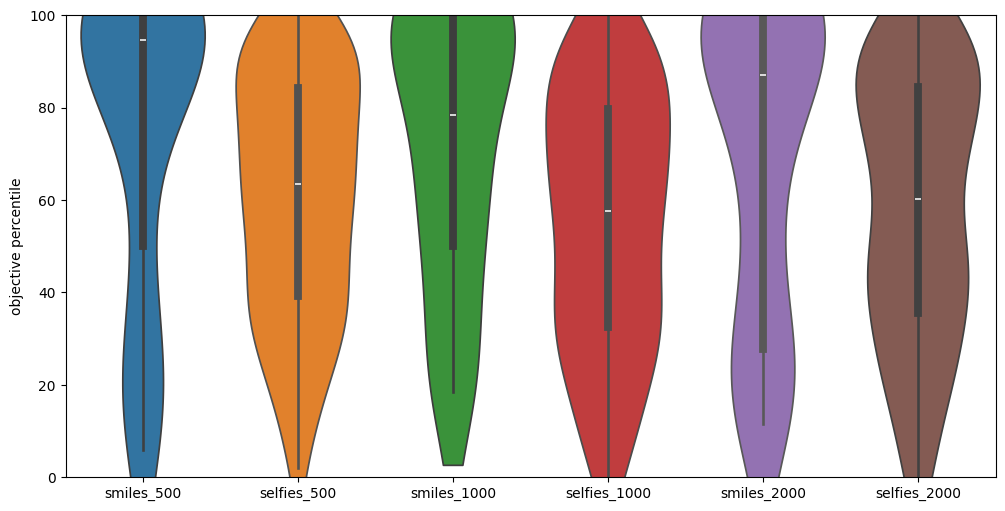

<module 'matplotlib.pyplot' from 'c:\\Users\\lisa0\\anaconda3\\envs\\LG_newmoses\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [51]:
def plot_violins(opt_dfs):
    plt.figure(figsize=(12, 6))
    for idx, df in enumerate(opt_dfs):
        pct_df = pd.DataFrame({'obj_pct': [percentileofscore(zinc_df['obj'], obj) for obj in set(df['obj'])]})
        sns.violinplot(x=idx, y='obj_pct', data=pct_df, cut=1)
        print(f'{idx} unique: {len(set(df["obj"]))}/{len(df)}')

    plt.xticks([idx for idx in range(len(opt_dfs))], ['smiles_500', 'selfies_500', 'smiles_1000', 'selfies_1000', 'smiles_2000', 'selfies_2000'])
    plt.ylabel('objective percentile')
    plt.ylim(0, 100)

    plt.show()
    return plt

plot_violins(opt_dfs)

In [58]:
best_opt = pd.DataFrame()
for idx, df in enumerate(opt_dfs):
    model_name = model_names[idx]
    best_opt[f'{model_name}'] = df['obj']

#display all the rows of the dataframe
pd.set_option('display.max_rows', None)
best_opt.describe()

,smiles_500,selfies_500,smiles_1000,selfies_1000,smiles_2000,selfies_2000
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.650952,1.851227,2.594905,1.725806,2.519846,1.803182
std,0.616613,0.508752,0.662273,0.573881,0.730278,0.645625
min,0.466382,0.074757,1.019013,-0.913642,0.777468,-1.013195
25%,2.898051,1.551409,2.898051,1.339826,2.773508,1.499884
50%,2.898051,1.762953,2.898051,1.719434,2.898051,1.800434
75%,2.898051,2.207153,2.898051,2.104822,2.898051,2.244161
max,3.091166,2.960659,3.091166,3.092794,3.091166,3.092794


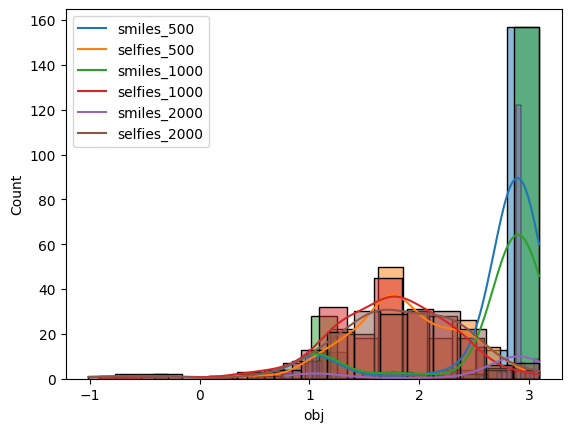

In [52]:
sns.histplot(smiles_500['obj'], kde=True)
sns.histplot(selfies_500['obj'], kde=True)
sns.histplot(smiles_1000['obj'], kde=True)
sns.histplot(selfies_1000['obj'], kde=True)
sns.histplot(smiles_2000['obj'], kde=True)
sns.histplot(selfies_2000['obj'], kde=True)

plt.legend(['smiles_500', 'selfies_500', 'smiles_1000', 'selfies_1000', 'smiles_2000', 'selfies_2000'])

plt.show()

### 2. temperature experiment


In [96]:
folder_path = '../checkpoints/ZINC250K_vae_property_obj_proploss_w0.1/'
config_file = 'vae_property_config.pt'
vocab_file = 'vae_property_vocab.pt'
model_file = 'vae_property_model.pt'

config = torch.load(f'{folder_path}{config_file}')
vocab = torch.load(f'{folder_path}{vocab_file}')

if config.model == 'vae':
    model = VAE(vocab, config)
elif config.model == 'vae_property':
    model = VAEPROPERTY(vocab, config)
    
model.load_state_dict(torch.load(f'{folder_path}{model_file}'))

trainer = VAEPROPERTYTrainer(config)

print(f'use selfies: {config.use_selfies}')

use selfies: False


In [97]:
if config.use_selfies:
    opt_df = selfies_2000
else:
    opt_df = smiles_2000

In [82]:
def sample_with_temp(opt_df, temp):
    str_z = np.array([z.strip('[]').split() for z in opt_df['z_value']])
    z_val = np.array([np.array(num, dtype=np.float32) for num in str_z])
    z_tensor = torch.tensor(z_val)
    z_tensor.shape

    if temp == 'argmax':
        opt_mol = model.sample(n_batch=z_tensor.shape[0], z=z_tensor, test=True)
    else:
        opt_mol = model.sample(n_batch=z_tensor.shape[0], z=z_tensor, temp=temp)

    opt_df = pd.DataFrame({'SELFIES' if config.use_selfies else 'SMILES': opt_mol})

    if config.use_selfies:
        opt_df.insert(1, 'SMILES', [sf.decoder(point) for point in opt_df['SELFIES']])

    opt_df['opt_romol'] = [get_mol(mol) for mol in opt_df['SMILES']]
    opt_df = opt_df.dropna(subset=['opt_romol'])

    opt_df['opt_logP'] = [logP(mol) for mol in opt_df['opt_romol']]
    opt_df['opt_qed'] = [QED(mol) for mol in opt_df['opt_romol']]
    opt_df['opt_SAS'] = [SA(mol) for mol in opt_df['opt_romol']]
    opt_df['opt_obj'] = 5*opt_df['opt_qed'] - opt_df['opt_SAS']

    return opt_df

In [94]:
def plot_violins(temps, opt_df, title):
    plt.figure(figsize=(12, 6))
    for idx, temp in enumerate(temps):
        temp_df = sample_with_temp(opt_df, temp)
        pct_df = pd.DataFrame({'obj_pct': [percentileofscore(zinc_df['obj'], obj) for obj in set(temp_df['opt_obj'])]})

        sns.violinplot(x=idx, y='obj_pct', data=pct_df, cut=1)

    plt.xticks([idx for idx in range(len(temps))], [temp if isinstance(temp, str) else round(temp, 2) for temp in temps])
    plt.ylabel('objective percentile')

    # set title
    plt.title(title)

    plt.show()
    return plt

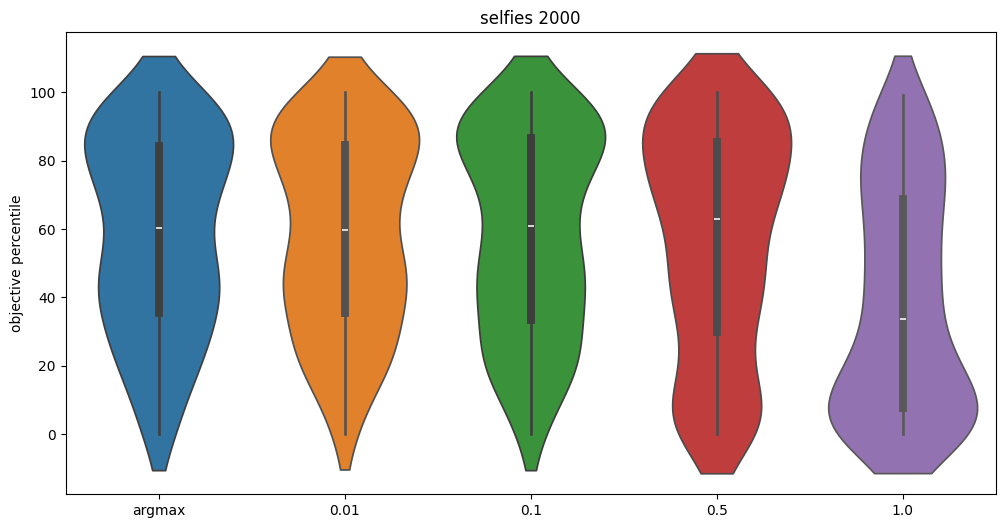

<module 'matplotlib.pyplot' from 'c:\\Users\\lisa0\\anaconda3\\envs\\LG_newmoses\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [95]:
temps = ['argmax', 0.01, 0.1, 0.5, 1.0]
plot_violins(temps, opt_df, 'selfies 2000')

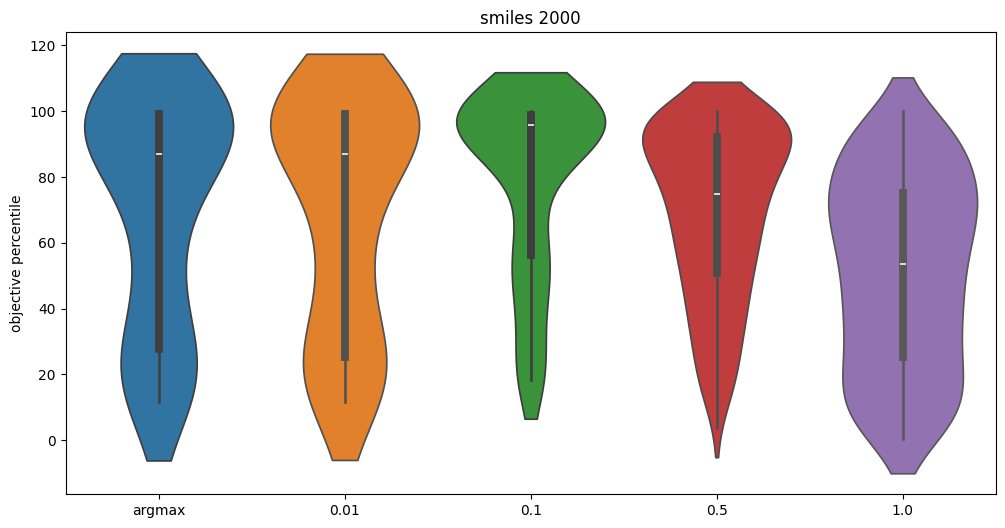

<module 'matplotlib.pyplot' from 'c:\\Users\\lisa0\\anaconda3\\envs\\LG_newmoses\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [98]:
plot_violins(temps, opt_df, 'smiles 2000')

Best

0 unique: 4/4
1 unique: 5/5
2 unique: 4/5
3 unique: 6/6
4 unique: 4/5
5 unique: 8/8


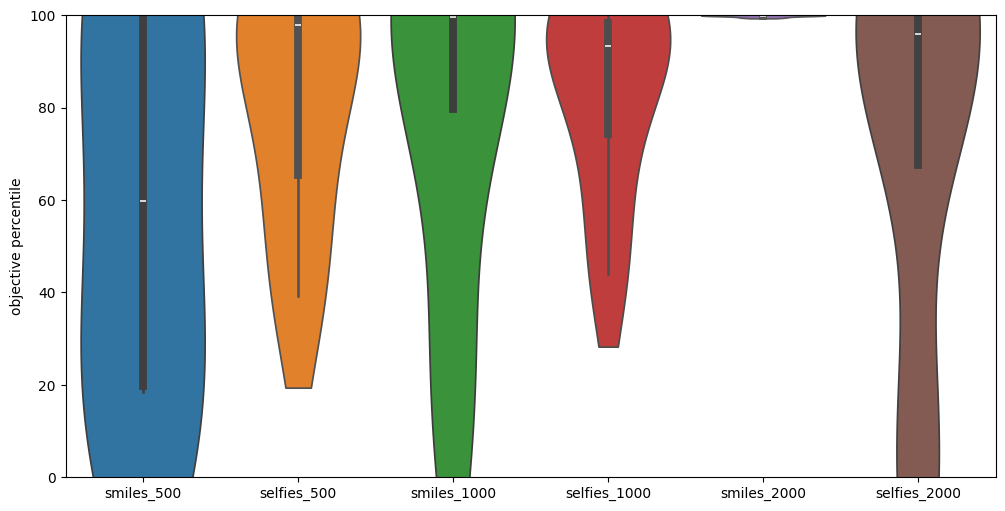

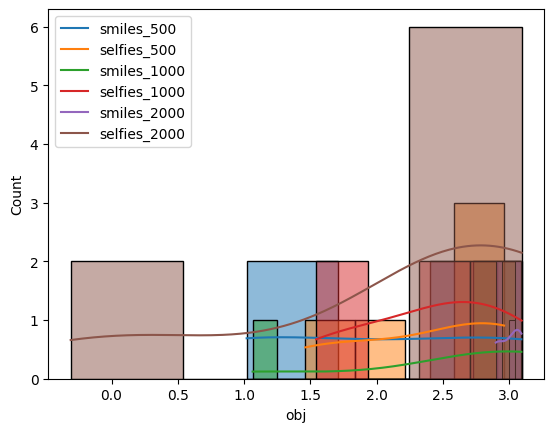

In [42]:
selfies_500 = pd.read_csv(f'{file_path}vae_prop_selfies_best_n500_ep200.csv')
selfies_1000 = pd.read_csv(f'{file_path}vae_prop_selfies_best_n1000_ep200.csv')
selfies_2000 = pd.read_csv(f'{file_path}vae_prop_selfies_best_n2000_ep200.csv')

smiles_500 = pd.read_csv(f'{file_path}vae_prop_smiles_best_n500_ep200.csv')
smiles_1000 = pd.read_csv(f'{file_path}vae_prop_smiles_best_n1000_ep200.csv')
smiles_2000 = pd.read_csv(f'{file_path}vae_prop_smiles_best_n2000_ep200.csv')

opt_dfs = [smiles_500, selfies_500, smiles_1000, selfies_1000, smiles_2000, selfies_2000]
model_names = ['smiles_500', 'selfies_500', 'smiles_1000', 'selfies_1000', 'smiles_2000', 'selfies_2000']
plot_violins(opt_dfs)

sns.histplot(smiles_500['obj'], kde=True)
sns.histplot(selfies_500['obj'], kde=True)
sns.histplot(smiles_1000['obj'], kde=True)
sns.histplot(selfies_1000['obj'], kde=True)
sns.histplot(smiles_2000['obj'], kde=True)
sns.histplot(selfies_2000['obj'], kde=True)

plt.legend(['smiles_500', 'selfies_500', 'smiles_1000', 'selfies_1000', 'smiles_2000', 'selfies_2000'])

plt.show()

In [46]:
best_opt = pd.DataFrame()
for idx, df in enumerate(opt_dfs):
    model_name = model_names[idx]
    best_opt[f'{model_name}'] = df['obj']

In [47]:
best_opt

,smiles_500,selfies_500,smiles_1000,selfies_1000,smiles_2000,selfies_2000
0,1.019013,1.883742,1.063931,1.543420,2.898051,-0.308118
1,1.063931,2.705721,2.898051,2.455165,3.036990,2.336916
2,2.898051,2.919944,3.063826,2.540812,3.071439,2.455165
3,3.091166,2.960659,3.091166,2.913771,3.091166,2.919944
